In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
df= pd.read_csv('auto.csv')

In [3]:
df.head()

,mpg,cylinders,acc,year
0,18.0,8,12.0,70
1,15.0,8,11.5,70
2,18.0,8,11.0,70
3,16.0,8,12.0,70
4,17.0,8,10.5,70


In [4]:
# create 10 categories with labels 1 to 10
df['acc'] = pd.qcut(df['acc'], q=10, labels=range(1, 11))


print(df)


      mpg  cylinders acc  year
0    18.0          8   1    70
1    15.0          8   1    70
2    18.0          8   1    70
3    16.0          8   1    70
4    17.0          8   1    70
..    ...        ...  ..   ...
387  27.0          4   6    82
388  44.0          4  10    82
389  32.0          4   1    82
390  28.0          4   9    82
391  31.0          4  10    82

[392 rows x 4 columns]


In [5]:
df['year'], bins = pd.qcut(df['year'], q=10, labels=range(1, 11), retbins=True)
print(bins)


[70. 71. 72. 73. 75. 76. 77. 78. 80. 81. 82.]


In [6]:
X= df.drop('mpg',axis=1)
y= df['mpg']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20,random_state=0)

In [8]:
import pandas as pd

def add_mean_columns(X_train, X_test, y_train):
    
    # Iterate over each column in X_train
    for column in X_train.columns:

        # Skip mean columns
        #if column.endswith('_mean'):
           # continue

        # Find the unique values in the column
        unique_values = X_train[column].unique()

        # Calculate the mean for each unique value using y_train
        means = {}
        for value in unique_values:
            means[value] = y_train[X_train[column] == value].mean()

        # Replace the column in X_train with the corresponding means
        X_train[column] = X_train[column].apply(lambda x: means[x])

        # Replace the column in X_test with the corresponding means
        X_test[column] = X_test[column].apply(lambda x: means[x] if x in means else x)

        # Check for unique values in X_test that are not in X_train
        missing_values = set(X_test[column].unique()) - set(X_train[column].unique())
        if missing_values:
            print(f"Warning: Unique values {missing_values} in {column} of X_test not found in X_train.")

    return X_train, X_test


In [9]:
X_train_new, X_test_new = add_mean_columns(X_train, X_test, y_train)

<ipython-input-8-957e0b8995f4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column] = X_train[column].apply(lambda x: means[x])
<ipython-input-8-957e0b8995f4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = X_test[column].apply(lambda x: means[x] if x in means else x)


In [10]:
X_test = X_test_new
X_train = X_train_new

In [11]:
X_test.isnull().sum()

cylinders    0
acc          0
year         0
dtype: int64

In [12]:
X_test

,cylinders,acc,year
144,29.336709,26.050000,21.581395
280,29.336709,26.784848,28.627907
68,15.012658,19.745161,18.900000
372,29.336709,26.050000,32.346154
328,29.336709,25.303571,28.627907
...,...,...,...
100,19.775362,22.863636,16.757576
64,15.012658,19.684375,18.900000
55,29.336709,27.978125,19.372093
260,15.012658,19.684375,23.562069


In [13]:
#X_test= X_test.to_numpy()
#X_train= X_train.to_numpy()
#y_test= y_test.to_numpy()
#y_train= y_train.to_numpy()

In [14]:
def prop_reg(X_test,X_train,y_train,y_test,kappa):
    d = np.zeros((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            d[i,j] = np.linalg.norm(X_test[i]-X_train[j])
    c=np.zeros(len(y_test))
    for i in range(len(y_test)):
        l=0
        v=0
        for j in range(len(y_train)):
            
            l+=y_train[j]/((1+d[i,j])**kappa)
            v+=1/((1+d[i,j])**kappa)
        
        c[i]=l/v
    return(c)

kappa = 1.000, avg MSE = 47.248
kappa = 2.000, avg MSE = 31.511
kappa = 3.000, avg MSE = 23.236
kappa = 4.000, avg MSE = 20.805
kappa = 5.000, avg MSE = 20.983
kappa = 6.000, avg MSE = 21.522
kappa = 7.000, avg MSE = 21.851
kappa = 8.000, avg MSE = 22.015
kappa = 9.000, avg MSE = 22.102


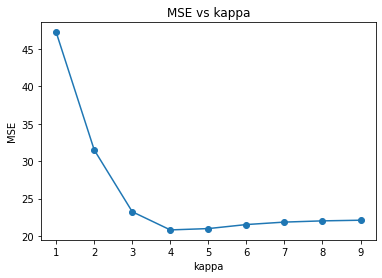

In [15]:
kf = KFold(n_splits=10)
kappa_values = np.array([1,2,3,4,5,6,7,8,9])
mse_values = []

for kappa in kappa_values:
    mse = 0.0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        y_pred = prop_reg(X_test, X_train, y_train, y_test, kappa)
        mse += mean_squared_error(y_test, y_pred)
    mse /= kf.get_n_splits(X)
    mse_values.append(mse)
    print(f"kappa = {kappa:.3f}, avg MSE = {mse:.3f}")

# plot the MSE vs kappa curve
plt.plot(kappa_values, mse_values, '-o')
plt.xlabel('kappa')
plt.ylabel('MSE')
plt.title('MSE vs kappa')
plt.show()
